# Snippets

short scripts worth keeping

In [1]:
%matplotlib inline
from collections import defaultdict
from constants import *
from os import listdir
from os.path import isfile, join
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
pd.options.display.max_rows = 2001

-----

## All corpora: Fix sent_idx in NLP

In [2]:
def fix_sent_idx(f, store=False):
    print("read", f)
    df = pd.read_pickle(f)
    columns = df.columns.tolist()
    len_old = len(df)
    size_old = df.size

    # create a count for each document
    df_group = pd.DataFrame(df.groupby(HASH).head(1)[HASH]).reset_index(drop=True)
    df_group['count'] = df_group.index

    # append count to original DataFrame
    df = df.merge(df_group[[HASH, 'count']], on=HASH)

    # add document count to sent_idx
    df['sent_idx'] += df['count']
    df = df[columns]
    len_new = len(df)
    size_new = df.size
    assert len_old == len_new
    assert size_old == size_new

    if store:
        print("write", f)
        df.to_pickle(f)

    #return df

In [3]:
# apply on nlp
path = NLP_PATH
number = None
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    if name.startswith('dewac'):
        gc.collect()
        gc.collect()
        f = join(path, name)
        fix_sent_idx(f, store=True)

read ../../master_cloud/corpora/preprocessed/nlp/dewac_04_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_04_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_05_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_05_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_06_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_06_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_07_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_07_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_08_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_08_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_09_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_09_nlp.pickle
read ../../master_cloud/corpora/preprocessed/nlp/dewac_10_nlp.pickle
write ../../master_cloud/corpora/preprocessed/nlp/dewac_10_nlp.pickle
read ../../master_cloud/cor

In [ ]:
# apply on simple ... will not work. better redo simple
path = SMPL_PATH
number = 2
files = sorted([f for f in listdir(path) if isfile(join(path, f))], key=lambda s: s.lower())
for name in files[:number]:
    f = join(path, name)
    df = fix_sent_idx(f, store=True)

In [ ]:
df.groupby(HASH, sort=False).apply(lambda x: x.head(5).append(x.tail(5)))[[SENT_IDX, TOK_IDX, TOKEN]]

-----

## Restoring original document hashes

for *_simple files (after accidental dtype conversion during phrase extraction)

In [ ]:
corpus = 'FAZ'
f = join(NLP_PATH, corpus + '_nlp.pickle')
dfn = pd.read_pickle(f)
f = join(SMPL_PATH, corpus + '_simple.pickle')
dfs = pd.read_pickle(f)

In [ ]:
pd.options.display.max_rows = 2005
dfn.loc[0:500, [HASH, SENT_IDX, TOK_IDX, TOKEN]]

In [ ]:
dfs = dfs.rename(columns={'hash': 'hash_wrong'})
dfs[0:300]
# hm this is bad: first word of document is in wrong order - better redo simple

In [ ]:
#dfs_u = dfs[SENT_IDX].unique()
dfng = dfn.groupby(['hash', SENT_IDX]).head(1)
dfsg = dfs.groupby(['hash_wrong', SENT_IDX]).head(1)

In [ ]:
dfsg[['hash_wrong', SENT_IDX, POS]]

In [ ]:
# 1) joining on index: -> not working
# 2) joining 
dfx = dfs.join(dfn[HASH])
dfx['diff'] = (dfx['hash_wrong'] - dfx[HASH]).abs()
dfx[[HASH, 'hash_wrong', 'diff']]

In [ ]:
dfx[dfx.POS == 'NPHRASE']

------

## preprocess FAZ

### Join FAZ and FAZ2 and remove duplicates

In [ ]:
fname1 = 'FAZ.pickle'
fpath1 = join(ETL_PATH, fname1)
df1 = pd.read_pickle(fpath1)
fname2 = 'FAZ2.pickle'
fpath2 = join(ETL_PATH, fname2)
df2 = pd.read_pickle(fpath2)

df1['new'] = False
combined = pd.concat([df1, df2])
c1 = combined
c2 = combined[~combined.duplicated(subset=[TITLE])]
c1.shape, c2.shape

In [ ]:
df = c2
del c1, c2, df1, df2
df = df[~df.subset.isin(
    [
        'angst-in-chemnitz-und-arroganz-im-dfb-team-15762511.html',
        'faz-net-sprinter-dumm-aber-sexy-15758998.html',
        'faz-net-sprinter-gehoert-sachsen-noch-zu-deutschland-15760532.html',
        'reise',
        #'rhein-main',
        'sport',
        #'technik-motor',
    ]
)]
df.groupby('subset').describe()

### Find encrypted articles (FAZ)

In [ ]:
# inspect the first entries to create a training set
df['str_len'] = df[TEXT].str.len()
half = df.apply(lambda x: x[TEXT][x['str_len']//2:], axis=1)
half.head(30)

In [ ]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
bad = df.loc[5598736571409986456, TEXT]
print(encryption_score(bad))

In [ ]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

In [ ]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [ ]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 350), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(350, 550), TEXT].tolist()
len(outlier1), len(outlier2)

In [ ]:
df = df[df.enc_score <= 300]
len(df)

In [ ]:
df = df.drop(['enc_score', 'str_len', 'new'], axis=1)
df.to_pickle(join(ETL_PATH, 'FAZ_combined.pickle'))
pd.read_pickle(join(ETL_PATH, 'FAZ_combined.pickle')).shape

### balanced sample of dataset (FAZ)

In [ ]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe().enc_score

In [ ]:
dfx.subset.head(25)

In [ ]:
dfx.subset.to_pickle(join(ETL_PATH, 'FAZ_document_sample3.pickle'))

------

## preprocess FOCUS

In [ ]:
fname1 = 'FOCUS_cleansed.pickle'
fpath1 = join(ETL_PATH, fname1)
df = pd.read_pickle(fpath1)

### Find bad encoded articles (FOCUS)

In [ ]:
# the first 25 articles are ok
trainset = df.iloc[:25][TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)
    
# compare scores for non-encrypted and encrypted articles
good = df.iloc[-20:][TEXT].tolist()
print([encryption_score(string) for string in good])
#bad = df.loc[5598736571409986456, TEXT]
#print(encryption_score(bad))

In [ ]:
# apply metric on corpus
df['enc_score'] = df[TEXT].apply(encryption_score)
df[[TEXT, 'enc_score']]

In [ ]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [ ]:
# 300 seems to be a valid limit. We don't loose too many good articles here
outlier1 = df.loc[df.enc_score.between(300, 500), TEXT].tolist()
outlier2 = df.loc[df.enc_score.between(400, 3000), TEXT].tolist()
len(outlier1), len(outlier2)

In [ ]:
outlier2

In [ ]:
df.groupby('subset').describe().enc_score

In [ ]:
df = df[df.enc_score <= 300]
len(df)

In [ ]:
df = df.drop(['enc_score'], axis=1)
df.to_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle'))
pd.read_pickle(join(ETL_PATH, 'FOCUS_cleansed.pickle')).shape

### balanced sample of dataset (FOCUS)

In [ ]:
dfx = df.sample(frac=1, random_state=12345)  # shuffle DataFrame for a random sample
dfx = dfx.groupby('subset').head(2000)
dfx.groupby('subset').describe()

In [ ]:
dfx.subset.to_pickle(join(ETL_PATH, 'FOCUS_document_sample3.pickle'))

### apply cleansing to nlp dataframe

In [ ]:
corpus = 'FAZ_combined'
f = join(ETL_PATH, corpus + '.pickle')
dfetl = pd.read_pickle(f)
corpus = 'FOCUS_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlp = pd.read_pickle(f)

In [ ]:
# remove problematic formatted articles
ev = np.unique(dfetl.index.values)
nv = np.unique(dfnlp.hash.values)
print(ev.size, nv.size)
print((np.union1d(ev, nv)).size, (np.intersect1d(ev, nv)).size)

dfnlpx = dfnlp[dfnlp.hash.isin(ev)]
print(dfnlpx.shape, dfnlp.shape)
print(dfnlpx.groupby(HASH).head(1).shape)

In [ ]:
# save
corpus = 'FOCUS_cleansed_nlp'
f = join(NLP_PATH, corpus + '.pickle')
dfnlpx.to_pickle(f)

-------

## preprocess Wikipedia

### Wikipedia - phrase extraction

#### - applying phrases on simple

In [ ]:
goodids = pd.read_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))

learn_phrases = False
if learn_phrases:
    phrases = pd.read_pickle(join(ETL_PATH, 'dewiki_phrases.pickle'))
    p = phrases.progress_apply(lambda x: x.str.cat(sep='_'), axis=1)
    p.to_pickle(join(ETL_PATH, 'dewiki_phrases_joined.pickle'))
else:
    p = pd.read_pickle(join(ETL_PATH, 'dewiki_phrases_joined.pickle'))

ps = set(p)
bad = {
    'ab', 'seit',
}
def ngrams(ser):
    if ser[0] not in bad:
        s = ser.str.cat(sep='_')
        size = len(ser)
        while size > 1:
            if (s in ps):
                return s, size
            s = s.rsplit('_', 1)[0]
            size -= 1
    return np.nan, 0

ps

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(SMPL_PATH)
                if (isfile(join(SMPL_PATH, f)) and pattern.match(f))])

for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(SMPL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df[df.hash.isin(goodids.index)]
    df = df.reset_index(drop=True)
    #df = df[:10_000]
    df['__2'] = df.token.shift(-1)
    df['__3'] = df.token.shift(-2)
    df['__4'] = df.token.shift(-3)
    df['__5'] = df.token.shift(-4)
    d = df[[TOKEN, '__2', '__3', '__4', '__5']].progress_apply(ngrams, axis=1)
    d = pd.DataFrame.from_records(d.tolist(), columns=['phrase', 'length'])
    mask = ~d.phrase.isnull()
    df = pd.concat([df, d], axis=1).drop(['__2', '__3', '__4', '__5'], axis=1)
    df.loc[mask, TOKEN] = df.loc[mask, 'phrase']
    df.loc[mask, POS] = 'NPHRASE'
    lv = df.length.values
    keep = np.ones_like(lv, dtype=bool)
    length = len(keep)
    for i, v in enumerate(lv):
        if v > 0:
            for j in range(i+1, min(i+v, length)):
                if lv[j] == 0:
                    keep[j] = False
    df['keep'] = keep
    df = df[df.keep].drop(['phrase', 'length', 'keep'], axis=1)
    df.to_pickle(f+'_x')


In [ ]:
print(df.dtypes)
df

#### - learning phrases from titles

In [ ]:
titles = []

def unique(ser):
    return ser.dropna().str.strip().unique()

f = 'dewiki_links.pickle'
dfl = pd.read_pickle(join(ETL_PATH, f))
f = 'dewiki_categories.pickle'
dfc = pd.read_pickle(join(ETL_PATH, f))

print(1, end=', ')
titles.append(unique(dfl.norm))
print(2, end=', ')
titles.append(unique(dfl.category))
print(3, end=', ')
titles.append(unique(dfc.category))
del dfc, dfl
gc.collect()
gc.collect()

pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    f = join(ETL_PATH, corpus + '.pickle')
    titles.append(unique(pd.read_pickle(f)[TITLE]))

print(titles)
df = pd.DataFrame(np.unique(np.hstack(titles)), columns=['phrase'])
del titles
gc.collect()
gc.collect()

print(df.head())
df['length'] = df.phrase.apply(lambda x: x.count(' ') + 1)
df = df[(df.length > 1) & (df.length < 6)]
r = re.compile(r'^[a-zA-Z0-9_äöüÄÖÜß]')
df = df[df.phrase.str.match(r)]

df = df['phrase']
print('expand')
df = df.str.split(' ', expand=True)
print('write')
df.to_pickle(join(ETL_PATH, 'dewiki_phrases.pickle'))

### replace document hashes with updates (Wikipedia)

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

mappings = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus)
    
    f = join(NLP_PATH, corpus + '_nlp.pickle')
    dfnlp = (
        pd.read_pickle(f)
        .groupby(HASH).head(1)[[HASH, TEXT]]
        .reset_index()
    )
    f = join(ETL_PATH, corpus + '.pickle')
    dfetl = (
        pd.read_pickle(f)
        .astype({
            DATASET: "category",
            SUBSET: "category", 
        })
        .reset_index()
        .join(dfnlp, rsuffix='_nlp')
    )
    dfjoin = dfetl[[HASH, TITLE, 'hash_nlp', 'text_nlp']].copy()
    dfjoin['equal_start'] = dfjoin.apply(lambda x: x.title.startswith(x.text_nlp), axis=1)
    #dfjoin['first_token'] = None
    #dfjoin['first_token'] = dfjoin.title.str.split(expand=True)
    #dfjoin['equal'] = (dfjoin.text_nlp == dfjoin.first_token)
    assert dfjoin.equal_start.sum() == len(dfjoin)
    dfetl = (
        dfetl
        .set_index('hash_nlp', drop=True)
        .drop(['text_nlp', 'hash', 'index'], axis=1)
    )
    dfetl.to_pickle(f)
    mappings.append(dfjoin[['hash', 'hash_nlp']])
    
dfmap = pd.concat(mappings)
dfmap = dfmap.set_index(HASH)['hash_nlp']
dfmap.to_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))
pd.read_pickle(join(ETL_PATH, 'dewiki_hashmap.pickle'))

In [ ]:
def replace_docid(f):
    print(f)
    df = (
        pd.read_pickle(join(ETL_PATH, f))
        .join(dfmap, on='doc_id')
        .drop('doc_id', axis=1)
    )
    df.to_pickle(join(ETL_PATH, f))

replace_docid('dewiki_categories.pickle')
replace_docid('dewiki_links.pickle')

### Find bad encoded articles (Wikipedia)

In [ ]:
pattern = re.compile(r'dewiki_\d')
files = sorted([f for f in listdir(ETL_PATH)
                if (isfile(join(ETL_PATH, f)) and pattern.match(f))])

In [ ]:
# take samples from the corpus as training set
samples = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df.loc[df.subset == 'ARTICLE']
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    sample_size = len(df) // 5_000
    print(len(df), sample_size)
    samples.append(df[[TITLE, TEXT]].sample(sample_size, random_state=1))

samples = pd.concat(samples)

In [ ]:
# remove a few problematic documents from training set
removable = [
    841808810294450851,
    -4692350076498843548,
    -8049734301321653789,
    -4131305296668036145,
    -8810233646059586724,
    2361495353241257464,
    2496670190106332015,
    7370294376993591077,
    -7758054498192490695,
    -4994773231110680494,
    2192724857258762575,
    1420892661644474111,
]
samples = samples[~samples.index.isin(removable)]
trainset = df[TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

In [ ]:
# comparing with FOCUS score
doc_freq = {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0}

distance = 0
for k in doc_freq.keys():
    distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
int(distance)

In [ ]:
def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)

good_ids = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(ETL_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    df = df.loc[df.subset == 'ARTICLE']
    df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    df['enc_score'] = df[TEXT].apply(encryption_score)
    # keep articles with distance < 400
    good_ids.append(df.loc[df.enc_score < 400, TITLE])

good_ids = pd.concat(good_ids)
good_ids

In [ ]:
good_ids.to_pickle(join(ETL_PATH, 'dewiki_good_ids.pickle'))

In [ ]:
df[[TEXT, 'enc_score']]

In [ ]:
# evaluate results
plt.scatter(df.index, df.enc_score)

In [ ]:
plt.hist(df.enc_score, bins=20)
# would be multimodal if not restircted to ARTICLEs

In [ ]:
# 400 seems to be a valid limit. We don't loose too many good articles here (~6 %)
#df[df.enc_score.between(400, 500)][TEXT].tolist()
len(df[df.enc_score > 400]) / len(df)

### collecting links from Wikipedia in a separate DataFrame

In [ ]:
# collecting links from Wikipedia in a separate DataFrame
LINK_LIST = []
TAGS_LIST = []

def collect_links(df):
    for doc_id, links in df[LINKS].iteritems():
        for link in links:
            LINK_LIST.append((doc_id, *link))

def collect_tags(df):
    for doc_id, categories in df[TAGS].iteritems():
        for category in categories:
            TAGS_LIST.append((doc_id, category))

pattern = re.compile(r'^dewiki_\d')
files = sorted([f for f in listdir(FULL_PATH)
                if isfile(join(FULL_PATH, f))
                and pattern.match(f)
               ])

for name in files:
    fname = join(ETL_PATH, name)
    print(fname)
    df = pd.read_pickle(fname)
    collect_links(df)
    collect_tags(df)

del df
df_links = pd.DataFrame.from_records(LINK_LIST, columns=['doc_id', 'link', 'norm', 'category'])
del LINK_LIST
df_tags = pd.DataFrame.from_records(TAGS_LIST, columns=['doc_id', 'category'])
del TAGS_LIST
df_links.to_pickle(join(ETL_PATH, 'dewiki_links.pickle'))
df_tags.to_pickle(join(ETL_PATH, 'dewiki_categories.pickle'))

### splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline

In [ ]:
# splitting the largest files from the wikipedia corpus to parallelize the nlp pipeline
fname = 'dewiki_01.pickle'
fpath = join(ETL_PATH, fname)
df = pd.read_pickle(fpath)
split = 25*1000
#split *= 2
dfs = [df[:1*split], 
       #df[1*split:], 
       df[1*split:2*split], 
       df[2*split:3*split], 
       df[3*split:]
      ]
length = sum([len(d) for d in dfs])
assert len(df) == length
df.shape, [d.shape for d in dfs]
fsplit = fpath.rsplit('.', 1)
for i, d in enumerate(dfs):
    f = "{}_{:d}.{}".format(fsplit[0], i, fsplit[1])
    print(f)
    d.to_pickle(f)

-------

## preprocess Dewac

(unlike to the earlier cells, the following code assumes that the data is placed in 'preprocessed/tmp/')

In [2]:
pattern = re.compile(r'dewac_\d')
files = sorted([f for f in listdir(TMP_PATH)
                if (isfile(join(TMP_PATH, f)) and pattern.match(f))])

In [4]:
# take samples from the corpus as training set
samples = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(TMP_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    #df = df.loc[df.subset == 'ARTICLE']
    #df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    sample_size = len(df) // 5_000
    print(len(df), sample_size)
    samples.append(df[[TITLE, TEXT]].sample(sample_size, random_state=1))

samples = pd.concat(samples)

dewac_01, 54907 10
dewac_02, 54991 10
dewac_03, 54977 10
dewac_04, 54829 10
dewac_05, 54968 10
dewac_06, 54986 10
dewac_07, 54966 10
dewac_08, 54959 10
dewac_09, 54986 10
dewac_10, 54560 10
dewac_11, 54990 10
dewac_12, 54999 10
dewac_13, 54987 10
dewac_14, 54999 10
dewac_15, 54997 10
dewac_16, 54988 10
dewac_17, 54953 10
dewac_18, 54807 10
dewac_19, 54946 10
dewac_20, 54950 10
dewac_21, 54944 10
dewac_22, 54818 10
dewac_23, 54980 10
dewac_24, 54993 10
dewac_25, 54976 10
dewac_26, 54962 10
dewac_27, 54996 10
dewac_28, 54994 10
dewac_29, 54991 10
dewac_30, 54975 10
dewac_31, 54937 10
dewac_32, 48560 9


In [6]:
samples[TEXT]

hash
-8157526149998639139    Moderator Volker Matthies mit Experte PD Dr. A...
-8139041734586718076    Zubereitung Den Lachs antauen laßen, in Würfel...
-6942140900391567610    Wussten Sie, dass die StadtBibliothek Köln die...
-8911096388020119024    29.06.05: Enquete-Kommission fordert Verbesser...
 6240926672015106313    Würzburg (rk/ag) Der Streit zwischen CDU und C...
 1959711681121568241    Ein besonders großes Danke für die Hilfe beim ...
-5830768473555351539    In Niedersachsen gibt es zur Zeit 993.000 Schü...
 9196780305889762322    Was geht uns das an: Christen und Politik Mona...
-1859898204671528775    In seiner literarischen Reportage "Die Hundees...
 4418799350836099921    Was Shakespeare nie zu schreiben wagte Die Fra...
 4430206916370824726    Neuer Chef des Planetariums plant digitale Tec...
 7803819644630133892    Nicht in jedem Fall ist bei ausländischen Küns...
-4630582756677073888    Zukunftsmanifest der IG Metall redet Entsolida...
-8857524272526221661    Protestbr

In [7]:
trainset = df[TEXT].tolist()
char_freq_train = defaultdict(int)
train_len = 0
FACTOR = 0.001
for string in trainset:
    train_len += len(string)
    for char in string.lower():
        char_freq_train[char] += 1
for k in char_freq_train.keys():
    char_freq_train[k] //= (train_len * FACTOR)
print(char_freq_train)

defaultdict(<class 'int'>, {'1': 2.0, '7': 0.0, '.': 9.0, '0': 2.0, '5': 0.0, '2': 1.0, '4': 0.0, ',': 8.0, ' ': 138.0, ':': 1.0, 'l': 30.0, 'a': 45.0, 'n': 82.0, 'd': 39.0, 'b': 17.0, 'e': 131.0, 'r': 60.0, 'i': 65.0, 't': 51.0, 'u': 33.0, 'h': 35.0, 'm': 21.0, 'f': 14.0, 's': 52.0, 'o': 21.0, 'v': 7.0, '/': 0.0, 'x': 0.0, 'ß': 1.0, 'w': 11.0, 'z': 10.0, 'k': 11.0, 'p': 7.0, 'ü': 5.0, 'g': 25.0, 'ä': 4.0, 'c': 23.0, '&': 0.0, 'q': 0.0, ';': 0.0, 'j': 1.0, '(': 1.0, ')': 1.0, '-': 2.0, '8': 0.0, '9': 1.0, 'y': 0.0, '6': 0.0, '3': 0.0, 'ö': 2.0, '"': 1.0, '=': 0.0, '\x96': 0.0, '\x84': 0.0, '\x93': 0.0, '?': 0.0, '+': 0.0, '*': 0.0, '#': 0.0, '©': 0.0, '!': 0.0, '@': 0.0, '[': 0.0, ']': 0.0, '<': 0.0, '_': 0.0, '´': 0.0, '|': 0.0, '»': 0.0, '«': 0.0, "'": 0.0, '`': 0.0, 'é': 0.0, '>': 0.0, '%': 0.0, '^': 0.0, '°': 0.0, '\x85': 0.0, '§': 0.0, '·': 0.0, '\xad': 0.0, 'à': 0.0, '\x9b': 0.0, '\x8b': 0.0, 'â': 0.0, '\x82': 0.0, '¬': 0.0, 'è': 0.0, 'î': 0.0, '\x80': 0.0, 'ó': 0.0, '\x94': 0.0,

In [8]:
# comparing with FOCUS score
doc_freq = {'b': 17.0, 'e': 134.0, 'i': 64.0, 'm': 20.0, ' ': 137.0, 'h': 35.0, 'z': 10.0, 'ö': 2.0, 'l': 33.0, '-': 4.0, 'k': 13.0, 'a': 47.0, 'u': 31.0, 'f': 13.0, 's': 53.0, 't': 52.0, 'd': 39.0, 'r': 58.0, 'c': 24.0, 'g': 22.0, 'n': 81.0, 'o': 26.0, '.': 9.0, 'w': 10.0, 'ü': 5.0, 'v': 7.0, ':': 1.0, ',': 6.0, 'p': 11.0, 'ä': 4.0, '8': 0.0, '1': 1.0, '2': 1.0, '0': 1.0, 'j': 1.0, '–': 0.0, 'ß': 1.0, '9': 0.0, '\n': 3.0, 'y': 1.0, '6': 0.0, '5': 0.0, '„': 0.0, '“': 0.0, '?': 0.0, '’': 0.0, '7': 0.0, 'x': 0.0, '(': 0.0, ')': 0.0, '*': 0.0, '3': 0.0, '4': 0.0, 'q': 0.0, '&': 0.0, ';': 0.0, '"': 0.0, '!': 0.0, '@': 0.0, '/': 0.0, "'": 0.0, '+': 0.0, 'é': 0.0}

distance = 0
for k in doc_freq.keys():
    distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
int(distance)

49

In [14]:
def encryption_score(string):
    distance = 0
    doc_freq = defaultdict(int)
    doc_len = len(string)//2
    if doc_len == 0:
        return 1000
    string = string[doc_len:]
    for char in string.lower():
        doc_freq[char] += 1
    for k in doc_freq.keys():
        doc_freq[k] //= (doc_len * FACTOR)
        distance += abs(doc_freq[k] - char_freq_train.get(k, 0))
    return int(distance)

good_ids = []
bad = []
for name in files[:]:
    gc.collect()
    gc.collect()
    corpus = name.split('.')[0]
    print(corpus, end=', ')
    
    f = join(TMP_PATH, corpus + '.pickle')
    df = pd.read_pickle(f)
    #df = df.loc[df.subset == 'ARTICLE']
    #df[TEXT] = df.text.str.replace(pat=r'\[\]|\]\]', repl='')
    df['enc_score'] = df[TEXT].apply(encryption_score)
    # keep articles with distance < 400
    good_ids.append(df.loc[df.enc_score < 400, TITLE])
    bad.append(df[df.enc_score >= 400])


dewac_01, dewac_02, dewac_03, dewac_04, dewac_05, dewac_06, dewac_07, dewac_08, dewac_09, dewac_10, dewac_11, dewac_12, dewac_13, dewac_14, dewac_15, dewac_16, dewac_17, dewac_18, dewac_19, dewac_20, dewac_21, dewac_22, dewac_23, dewac_24, dewac_25, dewac_26, dewac_27, dewac_28, dewac_29, dewac_30, dewac_31, dewac_32, 

In [20]:
bad = pd.concat(bad)
good_ids = pd.concat(good_ids)
good_ids.to_pickle(join(TMP_PATH, 'dewac_good_ids.pickle'))
len(bad) / (len(good_ids)+len(bad))

0.002495617542615866

In [17]:
bad[TEXT].tolist()

['Ein großes Dankeschön an alle, die für die Tiere gekommen sind und den Mut und die Ausdauer und die Kraft hatten, diese Nacht durchzustehen. Diese Tierversuchsgegner, die durchgehalten haben, sind echte Kämpfer für die Tiere, ihnen geht es nicht um Profilierung oder um "Pöstchen", nein, es geht ihnen nur um die Tiere, die dort eingeknastet sind und auf ihre Folter warten. Die Tierversuchsgegner waren eine Nacht lang hautnah bei den Tieren am "Höllenloch Kirchheimer Mühle" der Uni Heidelberg und des DKFZ. Alle, die dort waren, konnten später nach Hause gehen; die Tiere dort warten auf ihre Folterer und "Todeswissenschaftler". Die Tierversuchsgegner waren dem Grauen ganz nah und keine Macht und Geld wird sie davon abhalten, weiter gegen die Vivisektion und für das AUS dieses Tier-KZ\'s zu kämpfen. Hier die vorläufigen Termine für die nächsten Aktionen: 14.06. / 15.06.2003 12.07. / 13.07.2003 16.08. / 17.08.2003 13.09. / 14.09.2003 18.10. / 19.10.2003 Nacht-Aktionen haben stets den glei

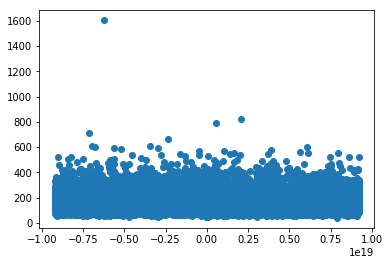

In [11]:
# evaluate results
plt.scatter(df.index, df.enc_score)

(array([1.1291e+04, 2.6785e+04, 8.8010e+03, 1.3570e+03, 2.2700e+02,
        6.5000e+01, 2.3000e+01, 7.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  39. ,  117.3,  195.6,  273.9,  352.2,  430.5,  508.8,  587.1,
         665.4,  743.7,  822. ,  900.3,  978.6, 1056.9, 1135.2, 1213.5,
        1291.8, 1370.1, 1448.4, 1526.7, 1605. ]),
 <a list of 20 Patch objects>)

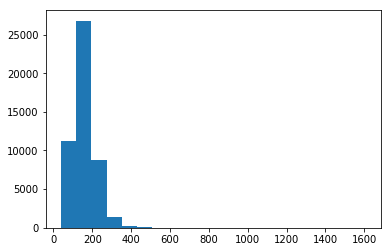

In [12]:
plt.hist(df.enc_score, bins=20)